# **Data Challenge - MDI 341**

### Description

The goal of this challenge is to develop a binary classification system which tries to detect if an image contains some property not (you can try to discover what these "properties" are).

As opposed to the previous challenge, we will follow a different procedure in this challenge. The challenge will have two phases. Please read the below information carefully.

**In the first phase** of the challenge, you will be provided a training dataset which contains the raw images and their corresponding labels. We will also provide you a validation dataset, which only contains the raw images. The labes of the validation set will not be provided. In this phase, you will train your system based on this data and the ranking in the challenge webpage will be based on your score obtained on the validation data.


**The second phase** of the challenge will start only a few hours (at most one day) before the deadline. Within this period, we will provide you the test set. You will need to run the algorithm that you developed on the first phase on this dataset and submit your predictions to the challenge webpage. Your final ranks will be determined on this dataset. Note that this phase will only last a few hours, which means that you will not be able to tune your algorithm on this dataset.



### Properties of the data set

- Training data:

The training set contains raw images and their labels. There are 116157 images in this dataset. Each image is of size 56 x 56 x 3 (the last dimension encodes the color information: red-green-blue). For each image there is a label, either 0 or 1.

- Validation data:

The validation set only contains raw images. There are 27013 images in this dataset, where the image format is the same as before. The labels of this dataset will not be provided. Within the first phase, your ranks will be calculated based on this dataset.

- Test data:

The test set only contains raw images as well. There will be 59429 images in this dataset, where the image format is the same as before. The labels of this dataset will not be provided either. This dataset will be provided only in the second phase: only a couple of hours before the challenge deadline. Your final ranks will be calculated based on this dataset.

Download link :
- Train Images: https://www.dropbox.com/s/486li09u91zyjdm/db_train.raw

- Labels: https://www.dropbox.com/s/d2hsorvtla3rtf9/label_2019_train.txt

- Validation Images: https://www.dropbox.com/s/qonk627t2557utz/db_val.raw



### Performance Criteria

As you will observe after examining the dataset, the data is highly unbalanced. Therefore, we choose a suitable criterion for evaluation: the performance criterion will be the average accuracy for each class.

As an example, if all your predictions are 0, then your score will be 50%. The higher the score, the better the performance.



# I. Exploratory Data Analysis

## 1. Import

In [0]:
### General Imports ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import math
from time import time
import pickle
from google.colab import drive

!pip3 install --quiet ggplot

from ggplot import *

### Visualization ###
import time
from sklearn.manifold import TSNE

### Deep Learning models ###
import tensorflow as tf
import tensorflow.keras

from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, model_from_json, Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, ZeroPadding2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D, AveragePooling2D

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Lambda

from tensorflow.keras.applications import densenet

### Large Scale Kernel ###
from scipy.sparse.linalg import svds
from scipy.linalg import svd
from scipy.sparse import csc_matrix
from numpy.linalg import multi_dot
from numpy.linalg import norm

### Classifiers ###
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC, LinearSVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

### HOG features ###
import scipy.misc
import dlib
import cv2
from skimage.feature import hog

### Image augmentation ###
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
import skimage.io

    100% |████████████████████████████████| 2.2MB 14.1MB/s 


/usr/local/lib/python3.6/dist-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/usr/local/lib/python3.6/dist-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


In [0]:
from keras import backend as K

In [0]:


from keras.layers import Flatten, Dense, Input, GlobalAveragePooling2D, \
    GlobalMaxPooling2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, \
    AveragePooling2D, Reshape, Permute, multiply
from keras_applications.imagenet_utils import _obtain_input_shape
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras import backend as K
from keras.engine.topology import get_source_inputs
import warnings
from keras.models import Model
from keras import layers

from functools import partial
from keras.models import Model
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Concatenate
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import add

If we use the TPU (Autoencoder faces issues) :

In [0]:
import os
try:
    device_name = os.environ['COLAB_TPU_ADDR']
    TPU_ADDRESS = 'grpc://' + device_name
    print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
    print('TPU not found')

TPU not found


In [0]:
def model_to_tpu(model):
    return tf.contrib.tpu.keras_to_tpu_model( model, strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))

## 2. Load the Data

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
shape_x = 56
shape_y = 56

In [0]:
train_images_fname = 'drive/My Drive/db_train.raw'
train_labels_fname = 'drive/My Drive/label_2019_train.txt'

val_images_fname    = 'drive/My Drive/db_val.raw'

# number of images
num_train_images = 116157
num_valid_images = 27013

# size of the images 56*56 pixels in gray levels
image_dim = shape_x * shape_y * 3

In [0]:
y_train = np.loadtxt(train_labels_fname, dtype=np.float64)
y_train_binary = tensorflow.keras.utils.to_categorical(y_train, 2)
class_weight = {0 : sum(y_train)/len(y_train), 1 : (len(y_train)-sum(y_train))/len(y_train)}

In [0]:
with open(train_images_fname, 'rb') as f:
    X_train = np.fromfile(f, dtype=np.uint8, count=num_train_images * image_dim).astype(np.float32)/255
    X_train = X_train.reshape(num_train_images, image_dim)

In [0]:
with open(val_images_fname, 'rb') as f:
    X_val = np.fromfile(f, dtype=np.uint8, count=num_valid_images * image_dim).astype(np.float32)
    X_val = X_val.reshape(num_valid_images, image_dim)

## 3. Data exploration

In [0]:
unique, counts = np.unique(y_train, return_counts=True)

In [0]:
unique, counts

(array([0., 1.]), array([47269, 68888]))

In [0]:
print("Number of observations belonging to class 0 : " + str(counts[0] / (counts[0]+counts[1])))

Number of observations belonging to class 0 : 0.4069406062484396


There is a slight class imbalance, but it shouldn't be a major issue.

### a. Visualize the images

In [0]:
# Investigation
print(X_train.shape)
print(y_train.shape)

(116157, 9408)
(116157,)


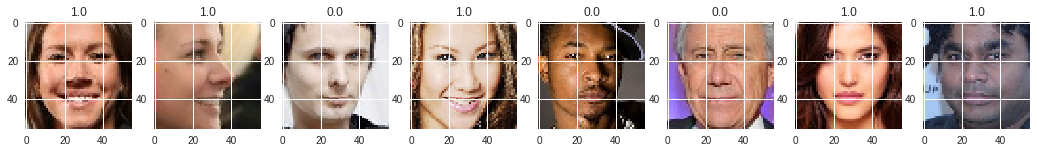

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(18, 4))

for i, ax in enumerate(axes):
    ax.imshow(X_train[i].reshape(shape_x, shape_y,3).astype(np.uint8))
    ax.set_title(y_train[i])

### b. Most important region

We don't know yet what the labels represent. For this reason, we'll try to identify the regions that are the most important by applying a feature importance over a XGBoost classifier.

In [0]:
model = XGBClassifier()
model.fit(X_train[:10000], y_train[:10000])
# feature importance
print(model.feature_importances_)

[0.       0.       0.       ... 0.002886 0.       0.      ]


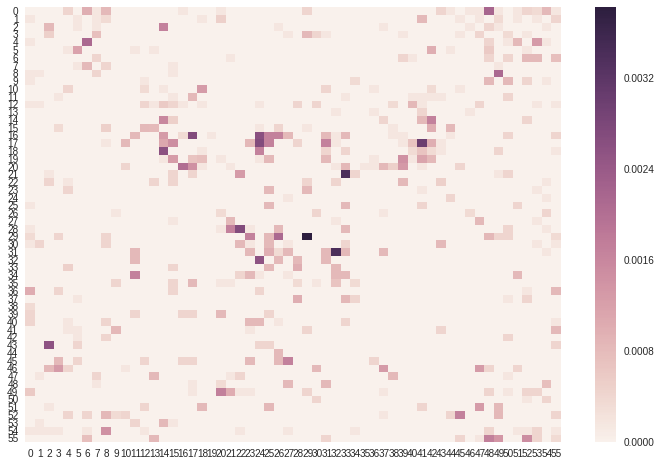

In [0]:
gray = cv2.cvtColor(model.feature_importances_.reshape(shape_x, shape_y,3), cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(12,8))
sns.heatmap(gray)
plt.show()

The eyes appear as the most important region we should focus on, and maybe the nose. To avoid adding noise to the image, we'll try to see if by setting an importance threshold, we are able to identify a specific region.

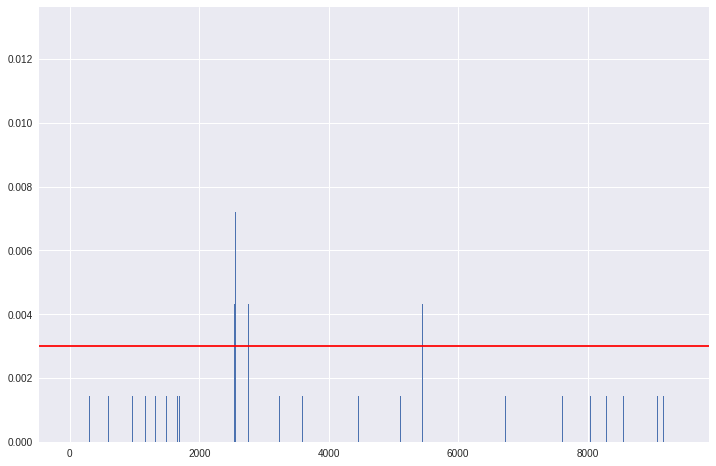

In [0]:
plt.figure(figsize=(12,8))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.axhline(y=0.003, color='r', linestyle='-')
plt.show()

We'll choose 0.003 as a threshold.

In [0]:
feature_importance = np.array(model.feature_importances_)>0.003
new = feature_importance*np.array(model.feature_importances_)

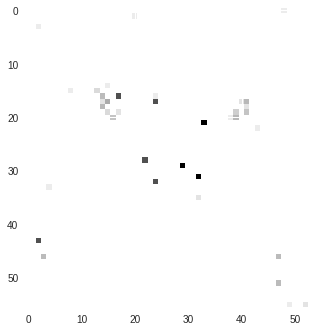

In [0]:
gray = cv2.cvtColor(new.reshape(shape_x, shape_y, 3), cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

In [0]:
X_train_crop = X_train.reshape(-1,shape_x, shape_y, 3)[:,5:25,10:50,:]
X_val_crop = X_val.reshape(-1,shape_x, shape_y, 3)[:,5:25,10:50,:]

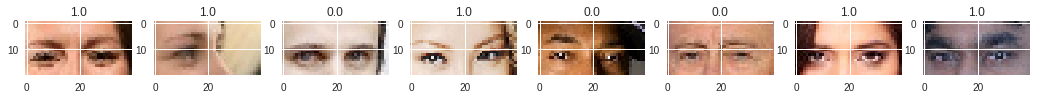

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(18, 4))

for i, ax in enumerate(axes):
    ax.imshow(X_train_crop[i].astype(np.uint8))
    ax.set_title(y_train[i])

The eyes appear as the single most important region. However, since gradient boosting methods do not perform so well, there is a large risk to overfit if we focus on this region in particular. 

### c. Average picture 

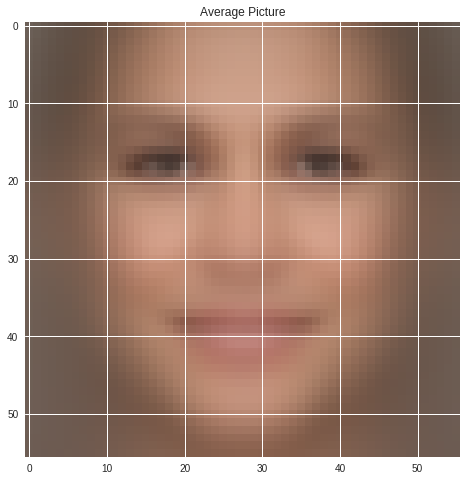

In [0]:
#Global average picture
avg_pic = np.mean(X_train, axis=0).astype('int').reshape(shape_x, shape_y, 3)

plt.figure(figsize=(12,8))
plt.imshow(avg_pic)
plt.title("Average Picture")
plt.show()

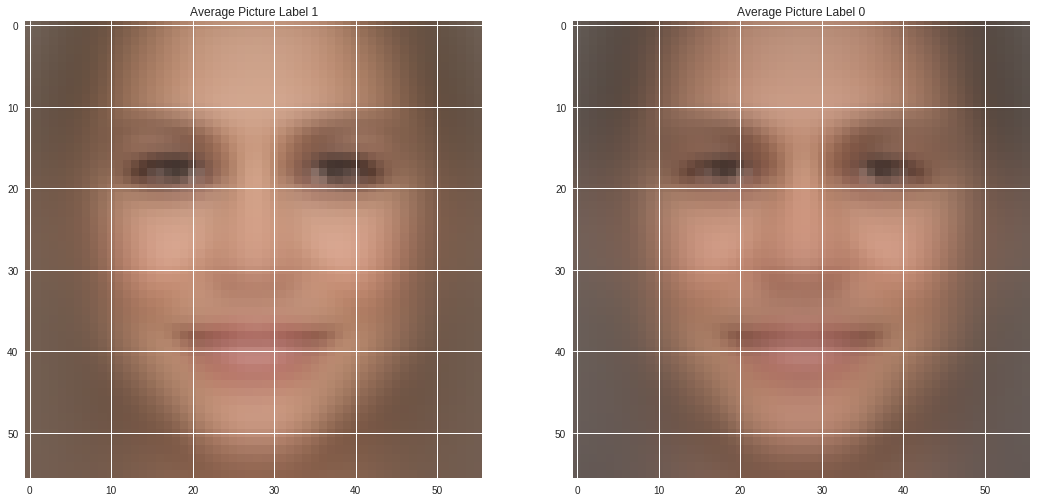

In [0]:
# Average picture label 1
avg_pic_1 = np.mean(X_train[np.where(y_train == 1)], axis=0).astype('int').reshape(shape_x, shape_y, 3)
avg_pic_0 = np.mean(X_train[np.where(y_train == 0)], axis=0).astype('int').reshape(shape_x, shape_y, 3)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))

axes[0].imshow(avg_pic_1)
axes[0].set_title("Average Picture Label 1")

axes[1].imshow(avg_pic_0)
axes[1].set_title("Average Picture Label 0")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


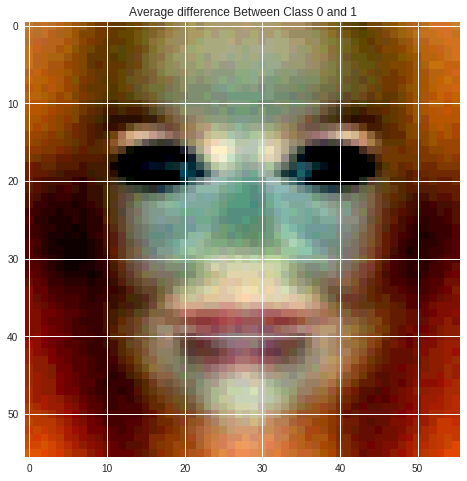

In [0]:
# Average substracted picture 

plt.figure(figsize=(12,8))
plt.imshow(((avg_pic_1 - avg_pic_0)/np.max(avg_pic_1 - avg_pic_0)*255).astype('int'), 'gray')
plt.title("Average difference Between Class 0 and 1")
plt.show()

### d. Distribution of the colors

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


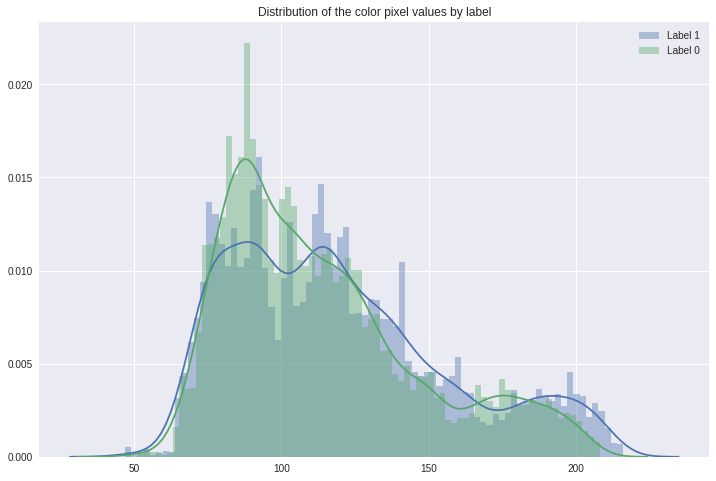

In [0]:
plt.figure(figsize=(12,8))
sns.distplot(avg_pic_1.flatten(), bins=80, kde=True, hist=True, label="Label 1")
sns.distplot(avg_pic_0.flatten(), bins=80, kde=True, hist=True, label="Label 0")
plt.title("Distribution of the color pixel values by label")
plt.legend()
plt.show()

### **e. Compare the train set and the validation set**

In [0]:
print("Total Elements in train : " + str(len(X_train)))
print("Unique Elements in train : " + str(len(np.unique(X_train, axis=0))))

Total Elements in train : 116157


In [0]:
print("Total Elements in val : " + str(len(X_val)))
print("Unique Elements in val : " + str(len(np.unique(X_val.reshape(-1,shape_x, shape_y,3), axis=0))))

Total Elements in val : 27013
Unique Elements in val : 27009


There's almost no duplicates among the train set and the validation set.

In [0]:
X_tot = np.concatenate((X_train, X_val), axis=0)
print("Total Elements in Tot : " + str(len(X_tot)))
print("Unique Elements in Tot : " + str(len(np.unique(X_tot.reshape(-1,800), axis=0))))

Total Elements in Tot : 143170
Unique Elements in Tot : 116104


We should be careful here. The images in the validation set are exactly the same than the ones in the training set. In order to prevent overfitting, we should :
- always apply cross validation when choosing a technique
- explore data augmentation techniques

### **f. Cross validation functions**

We need to define a custom cross validation function :

In [0]:
# Performance measure
def compute_pred_score(estimator, X, y_true):
  y_pred = estimator.predict(X)
  if(y_true.shape[0] != y_pred.shape[0]):
    raise Exception("y_pred and y_true must have the same size")
  tmp = np.unique(y_pred)
  if(tmp.shape[0] > 2):
    raise("y_pred should only contain 0 and 1")
        
  if(tmp.shape[0] == 1):
    if(tmp[0] != 0 and tmp[0] != 1):
      raise Exception("y_pred should only contain 0 and 1")
  else:
    if(tmp[0] != 0 and tmp[1] != 1):
      raise Exception("y_pred should only contain 0 and 1")
    
  y0 = (y_true == 0)
  y1 = (y_true == 1)
    
  acc1 = np.mean(1-y_pred[y0])
  acc2 = np.mean(y_pred[y1])
    
  return (acc1+acc2)/2

def score(y_val, y_test) :
  return K.mean(y_val*y_test + (1-y_val)*(1-y_test))

In [0]:
def cross_val(estimator, X_train, y_train, cv) :
  return cross_val_score(estimator, X_train, y_train, compute_pred_score, cv=cv)

**e. Data augmentation techniques**

In [0]:
def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

In [0]:
num_files_desired = 25000

# loop on all files of the folder and build a list of files paths

num_generated_files = 0

X_aug = X_train.copy()

available_transformations = {
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip
}

while num_generated_files <= num_files_desired:

    image_to_transform = random.choice(X_train.reshape(-1,20,40,1))
    # random num of transformation to apply
    num_transformations_to_apply = random.randint(1, len(available_transformations))

    num_transformations = 0
    
    while num_transformations <= num_transformations_to_apply:
        # random transformation to apply for a single image
        key = random.choice(list(available_transformations))
        modif_img = available_transformations[key](image_to_transform).reshape(1,20, 40, 1)

        X_aug = np.concatenate((X_aug, modif_img), axis=0)
        num_transformations += 1

We'll explore several strategies :
- apply a classifier on the flattened image
- build an autoencoder to reduce the dimension of the data and apply a classifier on top
- apply a convolutional neural network (CNN) on the input image
- build more complex architectures using neural networks (Inception, XCeption...)
- extract manually HOG and sliding HOG features and apply a SVM and a Random Kernel 


In [0]:
# In case this is needed later, transform the images to grayscale
X_train = (0.21 * X_train[:,:,:,0] + 0.72 * X_train[:,:,:,1] + 0.07 * X_train[:,:,:,2]).astype('int').reshape(-1,20,40,1)
X_val = (0.21 * X_val[:,:,:,0] + 0.72 * X_val[:,:,:,1] + 0.07 * X_val[:,:,:,2]).astype('int').reshape(-1,20,40,1)

# II. Predictive Models

## II.1 LGBM on flattened image

### a. Cross Validation

In [0]:
clf = LGBMClassifier(learning_rate = 0.1, num_leaves = 30, n_estimators=1000, verbose=1)
scores = cross_val_score(clf, X_train.reshape(-1,shape_x*shape_y*3), y_train, cv=5)

In [0]:
np.mean(scores)

0.7457837009957358

The classifier in a flat image heads an accuracy of 74.578%.

### **b. Prediction**

In [0]:
clf = LGBMClassifier(learning_rate = 0.1, num_leaves = 200, n_estimators=2000, verbose=1)
clf.fit(x_train, label_train)

In [0]:
filename = 'lgb.sav'
pickle.dump(clf, open(filename, 'wb'))

In [0]:
# Generate the prediction
val_pred = clf.predict(X_val)
np.savetxt("val_pred_clf.txt", val_pred, fmt="%d")

## II.2 Auto-Encoding for dimension reduction

### a. Define the autoencoder

In [0]:
input_img = Input(shape=(shape_x, shape_y, 3))

# Ecoding
x = Conv2D(2, (3, 3), padding='same', activation='relu')(input_img)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)
encoded = Conv2D(1,(3, 3), padding='same', activation='relu')(x)
 
# Decoding
x = Conv2D(1,(3, 3), padding='same', activation='relu')(encoded)
x = Conv2D(2,(3, 3), padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3,(3, 3), padding='same', activation = 'linear')(x)


Instructions for updating:
Colocations handled automatically by placer.


In [0]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
autoencoder.summary()

Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 56, 56, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 56, 2)         56        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 1)         19        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         10        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 2)         20        
_________________________________________________________________
up_sampling2d (UpSampling2D)

We'll fit our autoencoder an augmented data to avoid overfitting on the test part of the challenge.

In [0]:
epochs = 30
batch_size = 16

history = autoencoder.fit( (X_train).reshape(-1, shape_x, shape_y, 3), (X_train).reshape(-1, shape_x, shape_y, 3), batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 92925 samples, validate on 23232 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
92925/92925 [==============================] - 68s 733us/sample - loss: 0.0137 - val_loss: 0.0103
Epoch 2/30
92925/92925 [==============================] - 64s 684us/sample - loss: 0.0097 - val_loss: 0.0086
Epoch 3/30
92925/92925 [==============================] - 64s 684us/sample - loss: 0.0092 - val_loss: 0.0083
Epoch 4/30
92925/92925 [==============================] - 57s 610us/sample - loss: 0.0088 - val_loss: 0.0091
Epoch 5/30
92925/92925 [==============================] - 64s 684us/sample - loss: 0.0085 - val_loss: 0.0080
Epoch 6/30
92925/92925 [==============================] - 56s 608us/sample - loss: 0.0084 - val_loss: 0.0077
Epoch 7/30
92925/92925 [==============================] - 65s 699us/sample - loss: 0.0084 - val_loss: 0.0081
Epoch 8/30
92925/92925 [==============================] - 57s 611us/sample - loss: 0.0084 - val_loss: 0.0081
Epoch 9/30
92925/92925 [======

Text(0.5, 1.0, 'Loss Curves')

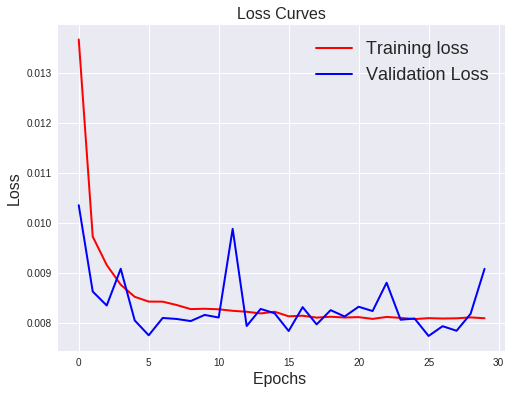

In [0]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

We can also implement an image data augmentation pipeline before fitting the encoder. There is however a potential issue with the data augmentation. Since the label is unknown, making data augmentation could mean that we loose some information (e.g if the label depends on the eye alignment...)

In [0]:
#autoencoder = model_to_tpu(autoencoder)
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

epochs = 20
batch_size = 32

autoencoder.fit_generator(
    datagen.flow(X_train.reshape(-1, shape_x, shape_y, 3), X_train.reshape(-1, shape_x, shape_y, 3), batch_size=batch_size),
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
    epochs = epochs)

NameError: ignored

We can save the trained encoder :

In [0]:
# Save autoencoder weight
json_string = autoencoder.to_json()
autoencoder.save_weights('drive/My Drive/autoencoder_final.h5')
open('drive/My Drive/autoencoder_final.h5', 'w').write(json_string)

4149

### b. Visualize the encoding

In [0]:
encoder = Model(inputs = input_img, outputs = encoded)

In [0]:
encoded_imgs = encoder.predict(X_train.reshape(-1,shape_x, shape_y, 3))
decoded_imgs = autoencoder.predict(X_train.reshape(-1,shape_x, shape_y, 3))

In [0]:
np.save('drive/My Drive/X_train_enc_final.npy', encoded_imgs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

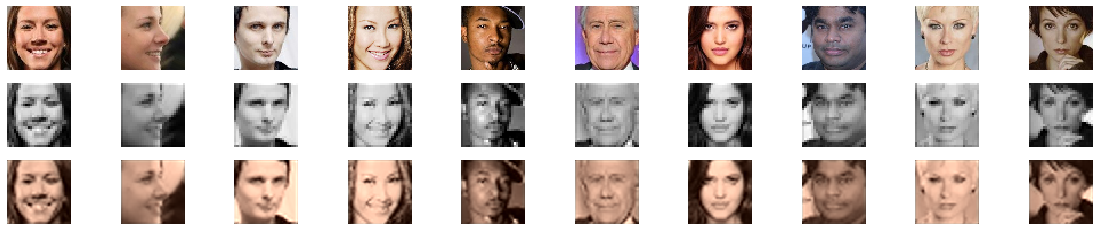

In [0]:
n = 10  
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_train[i].astype('int').reshape(shape_x, shape_y, 3), cmap='gray')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Encoded images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].astype('int').reshape(28,28), cmap='gray')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].astype('int').reshape(shape_x, shape_y, 3), cmap='gray')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

Through auto-encoding, we partly loose the color information. This could imply some issues on the final model and potentially explain a poor performance.

### c. Visualize the encoded images using T-SNE

T-SNE is often applied after a first large dimension reduction such as PCA. In this case, we apply T-SNE  after the auto-encoding to display our data in 2 dimensions.

In [0]:
rndperm = np.random.permutation(np.reshape(encoded_imgs, (-1,28*28)).shape[0])

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(np.reshape(encoded_imgs, (-1,28*28))[rndperm[:n_sne]])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.262s...
[t-SNE] Computed neighbors for 7000 samples in 71.802s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 5.234724
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.101479
[t-SNE] KL divergence after 300 iterations: 3.013362


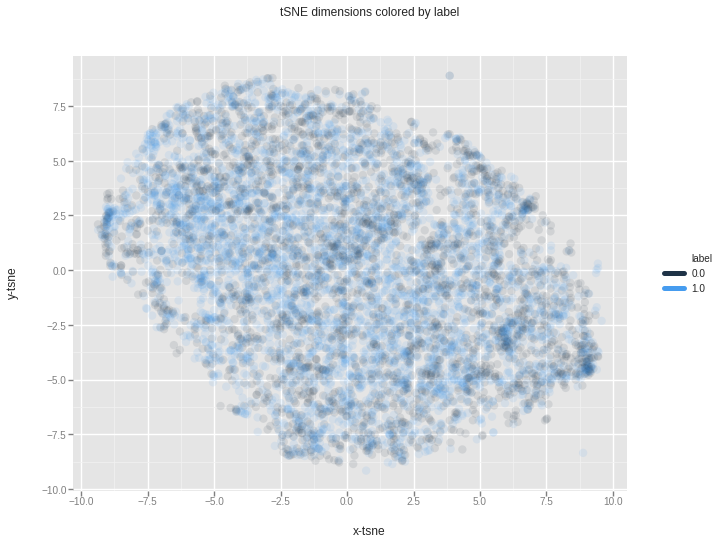

<ggplot: (-9223363308745036705)>

In [0]:
df_tsne = pd.DataFrame(np.reshape(encoded_imgs, (-1,28*28))[rndperm[:n_sne],:])
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]
df_tsne['label'] = y_train.flatten()[rndperm[:n_sne]]

chart = ggplot(df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by label")
chart

The representation does not bring clear representation of the data.

### d. Build a predictor on reduced data

In [0]:
encoded_imgs = np.load('drive/My Drive/X_train_enc.npy')/255

In [0]:
def createModel():
    model = Sequential()

    model.add(Conv2D(4, (3, 3), padding='same', input_shape=(28,28,1)))
    model.add(Conv2D(8, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.20))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.20))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(96))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(2))
    model.add(Activation('softmax'))

    return model

In [0]:
model = createModel()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 4)         40        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 8)         296       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 32)        0         
__________

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 30

history = model.fit(encoded_imgs.reshape(-1, 28, 28, 1), y_train_binary, batch_size=batch_size,validation_split=0.2,epochs = epochs, class_weight = class_weight)

Train on 92925 samples, validate on 23232 samples
Epoch 1/30
92925/92925 [==============================] - 30s 322us/sample - loss: 0.4576 - acc: 0.7636 - val_loss: 0.4305 - val_acc: 0.7820
Epoch 2/30
92925/92925 [==============================] - 28s 304us/sample - loss: 0.4239 - acc: 0.7857 - val_loss: 0.4099 - val_acc: 0.7953
Epoch 3/30
92925/92925 [==============================] - 28s 304us/sample - loss: 0.4048 - acc: 0.7974 - val_loss: 0.4158 - val_acc: 0.7822
Epoch 4/30
92925/92925 [==============================] - 28s 302us/sample - loss: 0.3886 - acc: 0.8062 - val_loss: 0.4018 - val_acc: 0.8028
Epoch 5/30
92925/92925 [==============================] - 28s 301us/sample - loss: 0.3746 - acc: 0.8166 - val_loss: 0.3983 - val_acc: 0.8061
Epoch 6/30
92925/92925 [==============================] - 28s 299us/sample - loss: 0.3596 - acc: 0.8230 - val_loss: 0.3962 - val_acc: 0.7992
Epoch 7/30
92925/92925 [==============================] - 29s 309us/sample - loss: 0.3452 - acc: 0.8325 

Text(0.5, 1.0, 'Accuracy Curves')

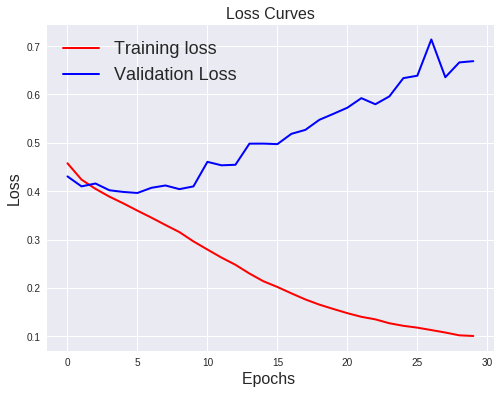

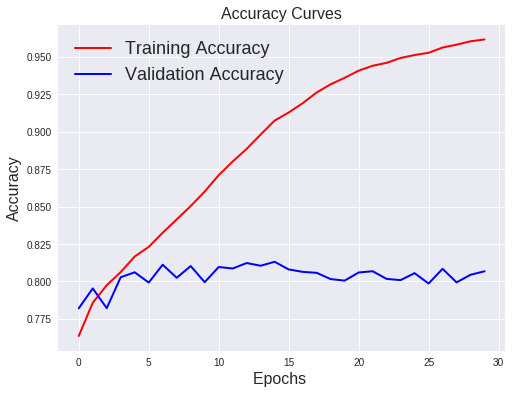

In [0]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=2.0)
plt.plot(history.history['val_acc'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

The accuracy in validation has issues going beyond 81%. Let's now test it on augmented images.

In [0]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

model = createModel()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size =128
epochs = 50

history = model.fit_generator(
    datagen.flow(encoded_imgs.reshape(-1, 28, 28, 1), y_train_binary, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
    epochs = epochs,
    class_weight = class_weight)

Epoch 1/50
908/908 [==============================] - 53s 58ms/step - loss: 0.6027 - acc: 0.6526
Epoch 2/50
908/908 [==============================] - 52s 57ms/step - loss: 0.5256 - acc: 0.7126
Epoch 3/50
908/908 [==============================] - 52s 57ms/step - loss: 0.5039 - acc: 0.7287
Epoch 4/50
908/908 [==============================] - 50s 56ms/step - loss: 0.4909 - acc: 0.7390
Epoch 5/50
908/908 [==============================] - 52s 58ms/step - loss: 0.4827 - acc: 0.7463
Epoch 6/50
908/908 [==============================] - 51s 56ms/step - loss: 0.4750 - acc: 0.7504
Epoch 7/50
908/908 [==============================] - 51s 56ms/step - loss: 0.4705 - acc: 0.7538
Epoch 8/50
908/908 [==============================] - 52s 57ms/step - loss: 0.4625 - acc: 0.7599
Epoch 9/50
908/908 [==============================] - 53s 59ms/step - loss: 0.4578 - acc: 0.7621
Epoch 10/50
908/908 [==============================] - 52s 57ms/step - loss: 0.4552 - acc: 0.7648
Epoch 11/50
908/908 [========

## II.3 Large Scale Kernel Method SVM

### Cross Validation

In [0]:
def random_features(X_train, X_test, gamma, c, seed=42):
    rng = np.random.RandomState(seed)
    n_samples, n_features = X_train.shape

    W = np.random.normal(0, np.sqrt(2*gamma), (n_features, c))
    b = np.random.uniform(0, 2*math.pi, (1,c))

    X_new_train = np.sqrt(2/n_features) * np.cos(np.dot(X_train, W) + b)
    X_new_test = np.sqrt(2/n_features) * np.cos(np.dot(X_test, W) + b)

    return X_new_train, X_new_test

In [0]:
n_samples, n_features = X_train.shape
gamma = 1. / n_features

In [0]:
Z_train = random_features(X_train.reshape(-1,800), gamma, c=100)

In [0]:
clf = LinearSVC(dual=False)
scores = cross_val(clf, Z_train, y_train, cv=3)

### Prediction

In [0]:
clf.fit(Z_train, y_train)

In [0]:
# Generate the prediction
val_pred = clf.predict(X_val)
np.savetxt("drive/My Drive/val_pred_lsk.txt", val_pred, fmt="%d")

## II.4 Convolutional Neural Network Architecture

### Build the model

In [0]:
def createModel():
    model = Sequential()

    model.add(Conv2D(4, (3, 3), padding='same', input_shape=(shape_x,shape_y,3)))
    model.add(Conv2D(8, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.20))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Dropout(0.20))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    model.add(Dense(96))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(2))
    model.add(Activation('softmax'))

    return model

In [0]:
model = createModel()

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 56, 56, 4)         112       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 8)         296       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 16)        1168      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 56, 56, 32)        4640      
_________________________________________________________________
batch_normalization_v1_36 (B (None, 56, 56, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
__________

### Fit with a validation set

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 256
epochs = 25

history = model.fit(X_train.reshape(-1, 56, 56, 3), y_train_binary, batch_size=batch_size,validation_split=0.2,epochs = epochs, class_weight = class_weight)

Train on 92925 samples, validate on 23232 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
92925/92925 [==============================] - 68s 727us/sample - loss: 0.4830 - acc: 0.7474 - val_loss: 0.4275 - val_acc: 0.7733
Epoch 2/25
92925/92925 [==============================] - 62s 672us/sample - loss: 0.3770 - acc: 0.8156 - val_loss: 0.3691 - val_acc: 0.8197
Epoch 3/25
92925/92925 [==============================] - 63s 674us/sample - loss: 0.3433 - acc: 0.8356 - val_loss: 0.3508 - val_acc: 0.8358
Epoch 4/25
92925/92925 [==============================] - 63s 674us/sample - loss: 0.3198 - acc: 0.8487 - val_loss: 0.3935 - val_acc: 0.7943
Epoch 5/25
92925/92925 [==============================] - 63s 673us/sample - loss: 0.2997 - acc: 0.8604 - val_loss: 0.3583 - val_acc: 0.8437
Epoch 6/25
92925/92925 [==============================] - 62s 672us/sample - loss: 0.2764 - acc: 0.8725 - val_loss: 0.3473 - val_acc: 0.8370
Epoch 7/25
92925/92925 [==============================] 

Text(0.5, 1.0, 'Accuracy Curves')

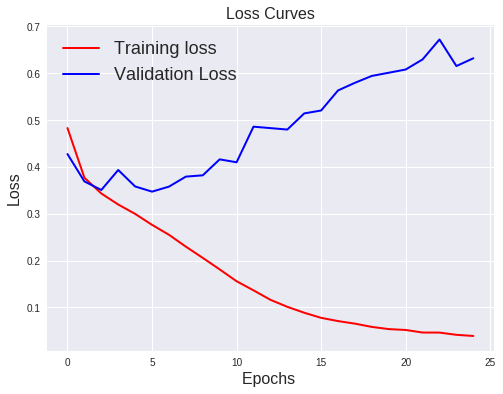

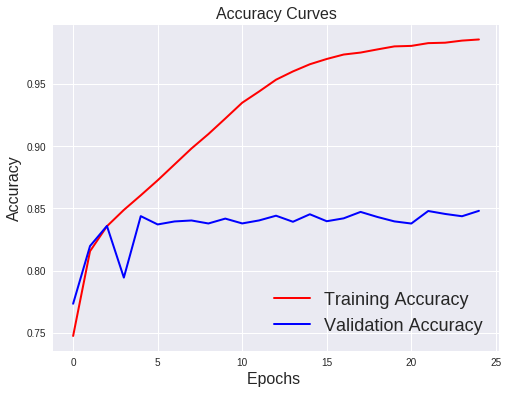

In [0]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=2.0)
plt.plot(history.history['val_acc'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

### Fit on the whole train set

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 64
epochs = 50

history = model.fit(X_train.reshape(-1, 56, 56, 3), y_train_binary, batch_size=batch_size, epochs = epochs, class_weight = class_weight)

Epoch 1/50
116157/116157 [==============================] - 108s 931us/sample - loss: 0.4380 - acc: 0.7790
Epoch 2/50
116157/116157 [==============================] - 107s 918us/sample - loss: 0.3627 - acc: 0.8247
Epoch 3/50
116157/116157 [==============================] - 106s 916us/sample - loss: 0.3391 - acc: 0.8396
Epoch 4/50
116157/116157 [==============================] - 107s 917us/sample - loss: 0.3180 - acc: 0.8502
Epoch 5/50
116157/116157 [==============================] - 106s 917us/sample - loss: 0.2963 - acc: 0.8620
Epoch 6/50
116157/116157 [==============================] - 107s 922us/sample - loss: 0.2732 - acc: 0.8739
Epoch 7/50
116157/116157 [==============================] - 107s 918us/sample - loss: 0.2457 - acc: 0.8897
Epoch 8/50
116157/116157 [==============================] - 107s 917us/sample - loss: 0.2175 - acc: 0.9050
Epoch 9/50
116157/116157 [==============================] - 106s 915us/sample - loss: 0.1864 - acc: 0.9206
Epoch 10/50
116157/116157 [==========

KeyboardInterrupt: ignored

In [0]:
# Save the weights
model.save('drive/My Drive/cnn_final.h5')
model.save_weights('drive/My Drive/cnn_final_weights')


Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


### Fit on Image Augmentation

In [0]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

model = createModel()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size =128
epochs = 50

history = model.fit_generator(
    datagen.flow(X_train.reshape(-1, shape_x, shape_y, 3), y_train_binary, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
    epochs = epochs,
    class_weight = class_weight)

Epoch 1/50
908/908 [==============================] - 158s 174ms/step - loss: 0.5314 - acc: 0.7103
Epoch 2/50
908/908 [==============================] - 157s 173ms/step - loss: 0.4319 - acc: 0.7802
Epoch 3/50
908/908 [==============================] - 157s 173ms/step - loss: 0.4059 - acc: 0.7978
Epoch 4/50
908/908 [==============================] - 159s 175ms/step - loss: 0.3915 - acc: 0.8064
Epoch 5/50
908/908 [==============================] - 159s 176ms/step - loss: 0.3819 - acc: 0.8138
Epoch 6/50
908/908 [==============================] - 158s 174ms/step - loss: 0.3744 - acc: 0.8187
Epoch 7/50
908/908 [==============================] - 157s 173ms/step - loss: 0.3678 - acc: 0.8220
Epoch 8/50
908/908 [==============================] - 158s 174ms/step - loss: 0.3644 - acc: 0.8221
Epoch 9/50
908/908 [==============================] - 154s 169ms/step - loss: 0.3578 - acc: 0.8265
Epoch 10/50
908/908 [==============================] - 158s 174ms/step - loss: 0.3564 - acc: 0.8279
Epoch 11/

KeyboardInterrupt: ignored

In [0]:
# Save the weights
model.save('drive/My Drive/cnn_aug_final.h5')
model.save_weights('drive/My Drive/cnn_aug_final_weights')


Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


## II.5 DenseNet

### Build the model

In [0]:
input_image = Input(shape=(shape_x, shape_y, 3))
x = BatchNormalization()(input_image)

base_model = densenet.DenseNet121(input_shape=(shape_x, shape_y, 3),
                             classes = 2,
                             weights=None,
                             include_top=False,
                             pooling='avg')


x = base_model(x)
x = Flatten()(x)
x = Dense(2, activation='softmax', name='fc2')(x)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model = Model(input_image, x)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 56, 56, 3)         0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 56, 56, 3)         12        
_________________________________________________________________
densenet121 (Model)          (None, 1024)              7037504   
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
fc2 (Dense)                  (None, 2)                 2050      
Total params: 7,039,566
Trainable params: 6,955,912
Non-trainable params: 83,654
_________________________________________________________________


### Fit with a validation set

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
 
batch_size = 256
epochs = 25

In [0]:
history = model.fit(X_train.reshape(-1,shape_x,shape_y,3), y_train_binary, batch_size=batch_size, epochs = epochs,validation_split = 0.2, class_weight = class_weight)

Train on 92925 samples, validate on 23232 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/25
92925/92925 [==============================] - 276s 3ms/sample - loss: 0.5107 - acc: 0.7256 - val_loss: 0.4688 - val_acc: 0.7904
Epoch 2/25
92925/92925 [==============================] - 245s 3ms/sample - loss: 0.4074 - acc: 0.8030 - val_loss: 1.0176 - val_acc: 0.6845
Epoch 3/25
92925/92925 [==============================] - 245s 3ms/sample - loss: 0.3730 - acc: 0.8221 - val_loss: 0.4202 - val_acc: 0.7986
Epoch 4/25
92925/92925 [==============================] - 245s 3ms/sample - loss: 0.3440 - acc: 0.8346 - val_loss: 0.3926 - val_acc: 0.8240
Epoch 5/25
92925/92925 [==============================] - 245s 3ms/sample - loss: 0.3237 - acc: 0.8463 - val_loss: 0.3447 - val_acc: 0.8394
Epoch 6/25
92925/92925 [==============================] - 245s 3ms/sample - loss: 0.3143 - acc: 0.8529 - val_loss: 1.3102 - val_acc: 0.7365
Epoch 7/25
92925/92925 [==============================] - 245s

Text(0.5, 1.0, 'Accuracy Curves')

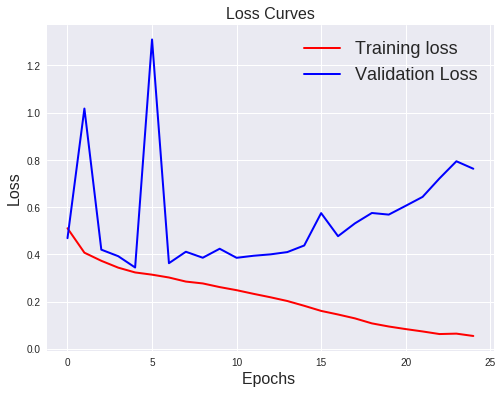

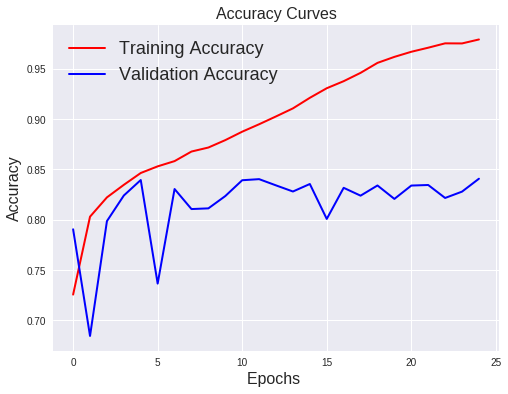

In [0]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=2.0)
plt.plot(history.history['val_acc'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

### Fit on the whole train set

In [0]:
batch_size = 128
epochs = 50
history = model.fit(X_train.reshape(-1,shape_x,shape_y,3), y_train_binary, batch_size=batch_size, epochs = epochs, class_weight = class_weight)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
116157/116157 [==============================] - 353s 3ms/sample - loss: 0.4795 - acc: 0.7539
Epoch 2/50
116157/116157 [==============================] - 327s 3ms/sample - loss: 0.3844 - acc: 0.8142
Epoch 3/50
116157/116157 [==============================] - 327s 3ms/sample - loss: 0.3572 - acc: 0.8278
Epoch 4/50
116157/116157 [==============================] - 327s 3ms/sample - loss: 0.3524 - acc: 0.8333
Epoch 5/50
116157/116157 [==============================] - 327s 3ms/sample - loss: 0.3293 - acc: 0.8437
Epoch 6/50
116157/116157 [==============================] - 328s 3ms/sample - loss: 0.3175 - acc: 0.8503
Epoch 7/50
116157/116157 [==============================] - 329s 3ms/sample - loss: 0.3180 - acc: 0.8525
Epoch 8/50
116157/116157 [==============================] - 328s 3ms/sample - loss: 0.2945 - acc: 0.8630
Epoch 9/50
116157/116157 [==============================] - 328s 3ms/sample - loss: 0.2811 - acc: 0.8691
Epoch 1

In [0]:
# Save the weights
model.save('drive/My Drive/dense_final.h5')
model.save_weights('drive/My Drive/dense_final_weights')


Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


### Fit on Augmented Images

In [0]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

model = createModel()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size =128
epochs = 50

history = model.fit_generator(
    datagen.flow(X_train.reshape(-1, shape_x, shape_y, 3), y_train_binary, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
    epochs = epochs,
    class_weight = class_weight)

In [0]:
# Save the weights
model.save('drive/My Drive/dense_aug_final.h5')
model.save_weights('drive/My Drive/dense_aug_final_weights')

## II.6 ResNet

### Build the model

In [0]:
import tensorflow.keras.applications.resnet50

input_image = Input(shape=(shape_x, shape_y, 3))
x = BatchNormalization()(input_image)

base_model = resnet50.ResNet50(weights= None, include_top=False, input_shape= (shape_x,shape_y,3))

x = base_model(x)
x = Flatten()(x)
x = Dense(2, activation='softmax', name='fc2')(x)

### Fit with a validation set

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
 
batch_size = 256
epochs = 25

In [0]:
history = model.fit(X_train.reshape(-1,shape_x,shape_y,3), y_train_binary, batch_size=batch_size, epochs = epochs,validation_split = 0.2, class_weight = class_weight)

Train on 92925 samples, validate on 23232 samples
Epoch 1/25


ResourceExhaustedError: ignored

In [0]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=2.0)
plt.plot(history.history['val_acc'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

### Fit on the whole train set

In [0]:
history = model.fit(X_train.reshape(-1,shape_x,shape_y,3), y_train_binary, batch_size=batch_size, epochs = epochs, class_weight = class_weight)

In [0]:
# Save the weights
model.save('drive/My Drive/inception_final.h5')
model.save_weights('drive/My Drive/inception_final_weights')

### Fit on Augmented Images

In [0]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

model = createModel()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 128
epochs = 50

history = model.fit_generator(
    datagen.flow(X_train.reshape(-1, shape_x, shape_y, 3), y_train_binary, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
    epochs = epochs,
    class_weight = class_weight)

Epoch 1/50
908/908 [==============================] - 160s 176ms/step - loss: 0.5369 - acc: 0.7060
Epoch 2/50
908/908 [==============================] - 159s 175ms/step - loss: 0.4379 - acc: 0.7748
Epoch 3/50
908/908 [==============================] - 158s 174ms/step - loss: 0.4069 - acc: 0.7971
Epoch 4/50
908/908 [==============================] - 159s 175ms/step - loss: 0.3937 - acc: 0.8050
Epoch 5/50
908/908 [==============================] - 158s 174ms/step - loss: 0.3824 - acc: 0.8131
Epoch 6/50
908/908 [==============================] - 161s 177ms/step - loss: 0.3752 - acc: 0.8170
Epoch 7/50
908/908 [==============================] - 160s 177ms/step - loss: 0.3708 - acc: 0.8195
Epoch 8/50
908/908 [==============================] - 161s 177ms/step - loss: 0.3642 - acc: 0.8239
Epoch 9/50
908/908 [==============================] - 159s 175ms/step - loss: 0.3602 - acc: 0.8272
Epoch 10/50
908/908 [==============================] - 160s 176ms/step - loss: 0.3570 - acc: 0.8283
Epoch 11/

In [0]:
# Save the weights
model.save('drive/My Drive/inception_aug_final.h5')
model.save_weights('drive/My Drive/inception_aug_final_weights')

## II.6 XCeption Model

### Build the model

In [0]:
def entry_flow(inputs) :
    
    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    previous_block_activation = x
    
    for size in [64, 128, 256] :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = MaxPooling2D(3, strides=2, padding='same')(x)
        
        residual = Conv2D(size, 1, strides=2, padding='same')(previous_block_activation)
        
        x = tensorflow.keras.layers.Add()([x, residual])
        previous_block_activation = x
    
    return x

In [0]:
def middle_flow(x, num_blocks=8) :
    
    previous_block_activation = x
    
    for _ in range(num_blocks) :
    
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
    
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = Activation('relu')(x)
        x = SeparableConv2D(256, 3, padding='same')(x)
        x = BatchNormalization()(x)
        
        x = tensorflow.keras.layers.Add()([x, previous_block_activation])
        previous_block_activation = x
    
    return x

In [0]:
def exit_flow(x) :
    
    previous_block_activation = x
    
    x = Activation('relu')(x)
    x = SeparableConv2D(256, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    
    residual = Conv2D(1024, 1, strides=2, padding='same')(previous_block_activation)
    x = tensorflow.keras.layers.Add()([x, residual])
      
    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    
    return x

In [0]:
inputs = Input(shape=(56, 56, 3))
outputs = exit_flow(middle_flow(entry_flow(inputs)))
xception = Model(inputs, outputs)

In [0]:
xception.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 56, 56, 3)    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 28, 28, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 28, 28, 32)   0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

### Fit with a validation set

In [0]:
xception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
 
batch_size = 128
epochs = 50

In [0]:
history = xception.fit(X_train.reshape(-1,56,56,3), y_train_binary, batch_size=batch_size, epochs = epochs, validation_split = 0.2 , class_weight = class_weight)

Train on 92925 samples, validate on 23232 samples
Epoch 1/50
92925/92925 [==============================] - 179s 2ms/sample - loss: 0.4427 - acc: 0.7738 - val_loss: 0.4675 - val_acc: 0.7721
Epoch 2/50
92925/92925 [==============================] - 164s 2ms/sample - loss: 0.3685 - acc: 0.8225 - val_loss: 0.4181 - val_acc: 0.8026
Epoch 3/50
92925/92925 [==============================] - 164s 2ms/sample - loss: 0.3422 - acc: 0.8375 - val_loss: 0.3718 - val_acc: 0.8194
Epoch 4/50
92925/92925 [==============================] - 164s 2ms/sample - loss: 0.3219 - acc: 0.8483 - val_loss: 0.4140 - val_acc: 0.8079
Epoch 5/50
92925/92925 [==============================] - 164s 2ms/sample - loss: 0.3089 - acc: 0.8548 - val_loss: 0.3638 - val_acc: 0.8343
Epoch 6/50
92925/92925 [==============================] - 163s 2ms/sample - loss: 0.2943 - acc: 0.8631 - val_loss: 0.3711 - val_acc: 0.8363
Epoch 7/50
92925/92925 [==============================] - 165s 2ms/sample - loss: 0.2796 - acc: 0.8706 - val_l

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Accuracy Curves')

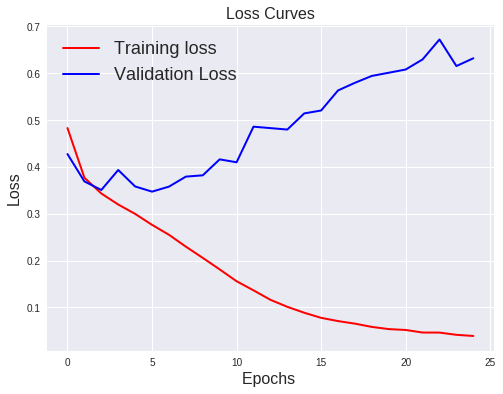

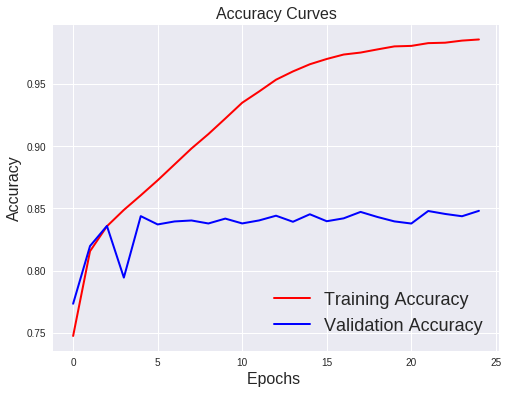

In [0]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=2.0)
plt.plot(history.history['val_acc'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

### Fit on the whole train set

In [0]:
xception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
 
history = xception.fit(X_train.reshape(-1,56,56,3), y_train_binary, batch_size=batch_size, epochs = epochs, class_weight = class_weight)

Epoch 1/50
116157/116157 [==============================] - 205s 2ms/sample - loss: 0.3852 - acc: 0.8111
Epoch 2/50
116157/116157 [==============================] - 198s 2ms/sample - loss: 0.3462 - acc: 0.8343
Epoch 3/50
116157/116157 [==============================] - 197s 2ms/sample - loss: 0.3235 - acc: 0.8460
Epoch 4/50
116157/116157 [==============================] - 197s 2ms/sample - loss: 0.3069 - acc: 0.8553
Epoch 5/50
116157/116157 [==============================] - 197s 2ms/sample - loss: 0.2931 - acc: 0.8644
Epoch 6/50
116157/116157 [==============================] - 197s 2ms/sample - loss: 0.2766 - acc: 0.8710
Epoch 7/50
116157/116157 [==============================] - 197s 2ms/sample - loss: 0.2622 - acc: 0.8803
Epoch 8/50
116157/116157 [==============================] - 198s 2ms/sample - loss: 0.2465 - acc: 0.8878
Epoch 9/50
116157/116157 [==============================] - 198s 2ms/sample - loss: 0.2319 - acc: 0.8960
Epoch 10/50
116157/116157 [============================

KeyboardInterrupt: ignored

In [0]:
xception.save_weights('drive/My Drive/xception_final_weights')
xception.save('drive/My Drive/xception_final.h5')


Consider using a TensorFlow optimizer from `tf.train`.


### Fit on Augmented Images

In [0]:
datagen = ImageDataGenerator(
        zoom_range=0.20,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.10,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.10,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

epochs = 35
batch_size = 128

xception = Model(inputs, outputs)
xception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


history = xception.fit_generator(
    datagen.flow(X_train.reshape(-1, shape_x, shape_y, 3), y_train_binary, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
    epochs = epochs,
    class_weight = class_weight)

Instructions for updating:
Use tf.cast instead.
Epoch 1/60
908/908 [==============================] - 208s 229ms/step - loss: 0.5102 - acc: 0.7234
Epoch 2/60
908/908 [==============================] - 198s 218ms/step - loss: 0.4301 - acc: 0.7831
Epoch 3/60
908/908 [==============================] - 198s 218ms/step - loss: 0.4026 - acc: 0.8002
Epoch 4/60
908/908 [==============================] - 198s 218ms/step - loss: 0.3907 - acc: 0.8081
Epoch 5/60
908/908 [==============================] - 199s 219ms/step - loss: 0.3796 - acc: 0.8145
Epoch 6/60
908/908 [==============================] - 199s 219ms/step - loss: 0.3713 - acc: 0.8190
Epoch 7/60
908/908 [==============================] - 199s 219ms/step - loss: 0.3631 - acc: 0.8245
Epoch 8/60
908/908 [==============================] - 199s 219ms/step - loss: 0.3580 - acc: 0.8276
Epoch 9/60
908/908 [==============================] - 199s 219ms/step - loss: 0.3534 - acc: 0.8301
Epoch 10/60
908/908 [==============================] - 198s 2

In [0]:
xception.save_weights('drive/My Drive/xception_aug_3_final_weights')
xception.save('drive/My Drive/xception_aug_3_final.h5')


Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


## II.8 VGG16 Face

### Build the model

In [0]:
def VGG16(classes=2) :
    input_shape = (shape_x,shape_y,3)

    img_input = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(
        img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(
        x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_2')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(
        x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_2')(
        x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_3')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_1')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_2')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv4_3')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2')(
        x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_3')(
        x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='pool5')(x)

    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dense(4096, name='fc6')(x)
    x = Activation('relu', name='fc6/relu')(x)
    x = Dense(2048, name='fc7')(x)
    x = Activation('relu', name='fc7/relu')(x)
    x = Dense(1024, name='fc8')(x)
    x = Activation('relu', name='fc8/relu')(x)
    x = Dense(256, name='fc9')(x)
    x = Activation('relu', name='fc9/relu')(x)
    x = Dense(128, name='fc10')(x)
    x = Activation('relu', name='fc10/relu')(x)
    x = Dense(classes, name='fc11')(x)
    x = Activation('softmax', name='fc11/softmax')(x)

    model = Model(img_input, x, name='vggface_vgg16')  # load weights
    
    return model

### Fit with a validation set

In [0]:
epochs = 50
batch_size = 128

model = VGG16(classes=2)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train.reshape(-1,56,56,3), y_train_binary, batch_size=batch_size, epochs = epochs, validation_split=0.1, class_weight = class_weight)

Train on 104541 samples, validate on 11616 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
104541/104541 [==============================] - 237s 2ms/sample - loss: 7.9693 - acc: 0.5942 - val_loss: 8.2246 - val_acc: 0.5796
Epoch 2/50
 42880/104541 [===========>..................] - ETA: 2:10 - loss: 7.9708 - acc: 0.5950

KeyboardInterrupt: ignored

In [0]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=2.0)
plt.plot(history.history['val_acc'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

### Fit on the whole train set

In [0]:
history = model.fit(X_train.reshape(-1,56,56,3), y_train_binary, batch_size=batch_size, epochs = epochs, class_weight = class_weight)

In [0]:
model.save_weights('drive/My Drive/vgg_final_weights')
model.save('drive/My Drive/vgg_final.h5')

### Fit on Augmented Images

In [0]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

epochs = 50
batch_size = 256

model = VGG16(classes=2)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit_generator(
    datagen.flow(X_train.reshape(-1, shape_x, shape_y, 3), y_train_binary, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
    epochs = epochs,
    class_weight = class_weight)

Epoch 1/50
454/454 [==============================] - 233s 513ms/step - loss: 12660154423.2848 - acc: 0.5838 - score: 2.7105 - categorical_accuracy: 1.0000
Epoch 2/50
454/454 [==============================] - 223s 491ms/step - loss: 11597.8340 - acc: 0.6584 - score: 0.5870 - categorical_accuracy: 1.0000
Epoch 3/50
454/454 [==============================] - 223s 492ms/step - loss: 10362.8866 - acc: 0.6980 - score: 0.6311 - categorical_accuracy: 1.0000
Epoch 4/50
454/454 [==============================] - 223s 492ms/step - loss: 9418.1374 - acc: 0.7330 - score: 0.6647 - categorical_accuracy: 1.0000
Epoch 5/50
454/454 [==============================] - 223s 492ms/step - loss: 8826.1992 - acc: 0.7518 - score: 0.6862 - categorical_accuracy: 1.0000
Epoch 6/50
454/454 [==============================] - 224s 492ms/step - loss: 8414.0922 - acc: 0.7685 - score: 0.7009 - categorical_accuracy: 1.0000
Epoch 7/50
454/454 [==============================] - 224s 493ms/step - loss: 8063.9049 - acc: 0.

In [0]:
model.save_weights('drive/My Drive/vgg_aug_final_weights')
model.save('drive/My Drive/vgg_aug_final.h5')

## II.9  HOG features and SVM 

In [0]:
window_size = 24
window_step = 6

In [0]:
def sliding_hog_windows(image):
    hog_windows = []
    for y in range(0, shape_x, window_step):
        for x in range(0, shape_y, window_step):
            window = image[y:y+window_size, x:x+window_size]
            hog_windows.extend(hog(window, orientations=8, pixels_per_cell=(8, 8),
                                            cells_per_block=(1, 1), visualise=False))
    return hog_windows

In [0]:
hog_features = []
hog_images = []

for i in range(len(X_train)):
    try:
        # Build the image as an array
        image = X_train[i].reshape((shape_x, shape_y, 3))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # HOG features
        features, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualise=True)
        hog_features.append(features)
        hog_images.append(hog_image)

    except Exception as e:
        print( "error in image: " + str(i) + " - " + str(e))

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [0]:
# Visualize the HOG 
plt.imshow(images[0].reshape((shape_x, shape_y)))

In [0]:
model = SVC(random_state=42, max_iter=10000, kernel='rbf',gamma='auto')

# Train
model.fit(hog_features, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=10000, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [0]:
hog_features_test = []

for i in range(len(X_val)):
    try:
        # Build the image as an array
        image = X_train[i].reshape((shape_x, shape_y, 3))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # HOG features
        features, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualise=True)
        hog_features_test.append(features)

    except Exception as e:
        print( "error in image: " + str(i) + " - " + str(e))

/usr/local/lib/python3.6/dist-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [0]:
# Generate the prediction
val_pred = model.predict(hog_features_test)
np.savetxt("drive/My Drive/val_pred_hog.txt", val_pred, fmt="%d")

# III. Model soft probabilities

In [0]:
pred = model.predict(X_train.reshape(-1, shape_x, shape_y, 3))

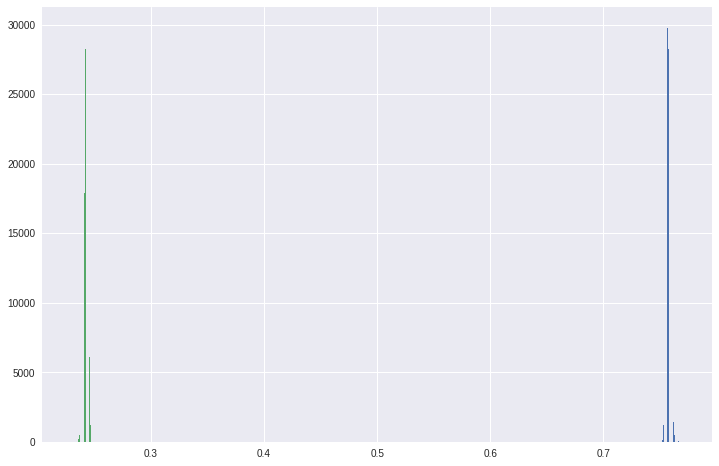

In [0]:
plt.figure(figsize=(12,8))
plt.hist(pred, bins=500)
plt.show()

In [0]:
print(len(pred))
len(pred[pred > 0.2][pred[pred > 0.2]<0.8])

116157


232314

# IV. Make predictions on the test set

## 1. Load the data

In [0]:
test_images_fname = 'drive/My Drive/db_test.raw'
num_test_images = 59429

In [0]:
with open(test_images_fname, 'rb') as f:
    X_test = np.fromfile(f, dtype=np.uint8, count=num_train_images * image_dim).astype(np.float32)
    X_test = X_test.reshape(num_test_images, image_dim)

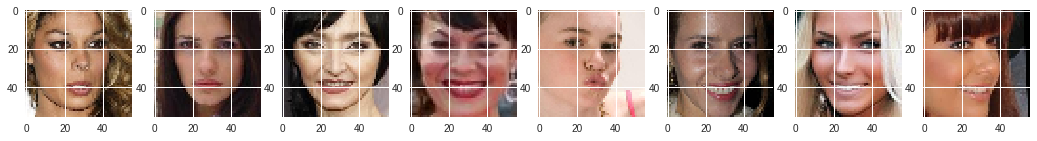

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(18, 4))

for i, ax in enumerate(axes):
    ax.imshow(X_test[i].reshape(shape_x, shape_y,3).astype(np.uint8))

## 2. Load the pre-trained model

In [0]:
list_path_h5 = ['drive/My Drive/cnn_final.h5', 
                'drive/My Drive/inception_final.h5', 
                'drive/My Drive/xception_final.h5', 
                'drive/My Drive/facenet_final.h5',
                'drive/My Drive/vgg_final.h5',
                'drive/My Drive/dense_final.h5',
                
                
                'drive/My Drive/cnn_aug_final.h5', 
                'drive/My Drive/inception_aug_final.h5', 
                'drive/My Drive/xception_aug_final.h5', 
                'drive/My Drive/xception_aug_3_final.h5', 
                'drive/My Drive/facenet_aug_final.h5',
                'drive/My Drive/vgg_aug_final.h5',
               ]

model_chosen = list_path_h5[8]

In [0]:
model = tensorflow.keras.models.load_model(model_chosen)

## 3. Make prediction

In [0]:
pred = model.predict(X_test.reshape(-1, shape_x, shape_y, 3)).argmax(axis=-1)
#pred = model.predict(X_val.reshape(-1, shape_x, shape_y, 3)).argmax(axis=-1)

np.savetxt("drive/My Drive/prediction_dense_1.txt", pred, fmt="%d")

## 4. All predictions

In [0]:
for i in list_path_h5 :
  model = tensorflow.keras.models.load_model(i)
  pred = model.predict(X_test.reshape(-1, shape_x, shape_y, 3)).argmax(axis=-1)
  np.savetxt("drive/My Drive/prediction_%d.txt" %(i), val_pred, fmt="%d")

In [0]:
# Restore the weights
#model = Model(inputs, outputs)
#model.load_weights('drive/My Drive/xception_final_weights')
#model.summary()

# V. Ensemble model

In [0]:
list_path_h5 = ['drive/My Drive/cnn_final.h5', 
                'drive/My Drive/xception_final.h5', 
                'drive/My Drive/xception_aug_final.h5', 
                'drive/My Drive/xception_aug_3_final.h5', 
               ]

In [0]:
train_pred = pd.DataFrame()

for i in list_path_h5 :
  model = tensorflow.keras.models.load_model(i)
  pred = model.predict(X_train.reshape(-1, shape_x, shape_y, 3))
  train_pred = pd.concat([train_pred, pd.DataFrame(pred)], axis=1)

In [0]:
train_pred = pd.concat( [ 
    pd.DataFrame( np.array( (train_pred.iloc[:,0], train_pred.iloc[:,2], train_pred.iloc[:,4], train_pred.iloc[:,6]) )), 
    pd.DataFrame( np.array((train_pred.iloc[:,1], train_pred.iloc[:,3], train_pred.iloc[:,5], train_pred.iloc[:,7]) ))
    ]).T

In [0]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf.fit(train_pred, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [0]:
test_pred = pd.DataFrame()

for i in list_path_h5 :
  model = tensorflow.keras.models.load_model(i)
  pred = model.predict(X_test.reshape(-1, shape_x, shape_y, 3))
  test_pred = pd.concat([test_pred, pd.DataFrame(pred)], axis=1)

In [0]:
test_pred = pd.concat( [ 
    pd.DataFrame( np.array( (test_pred.iloc[:,0], test_pred.iloc[:,2], test_pred.iloc[:,4], test_pred.iloc[:,6]) )), 
    pd.DataFrame( np.array((test_pred.iloc[:,1], test_pred.iloc[:,3], test_pred.iloc[:,5], test_pred.iloc[:,7]) ))
    ]).T

In [0]:
pred = clf.predict(test_pred)
np.savetxt("drive/My Drive/prediction_ensemble.txt", pred, fmt="%d")

# Optimize the train set (Not used)

In [0]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [0]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

In [0]:
neighbors_idx_list = np.unique(np.ravel(knn.kneighbors(X_test)[1]))

In [0]:
X_train_new = X_train.iloc[neighbors_idx_list, :]
y_train_new = y_train.iloc[neighbors_idx_list]